In [1]:
#
# COMMENTS TO DO
#
#Condensed code based on the code from: https://jmetzen.github.io/2015-11-27/vae.html

%matplotlib inline
import tensorflow as tf
import tensorflow.contrib.layers as layers
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import os
import time
import glob

from tensorflow.examples.tutorials.mnist import input_data

def plot(samples, w, h, fw, fh, iw=28, ih=28):
    fig = plt.figure(figsize=(fw, fh))
    gs = gridspec.GridSpec(w, h)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(iw, ih), cmap='Greys_r')

    return fig


def encoder(images, num_outputs_h0=16, num_outputs_h1=32, kernel_size=5, stride=2, num_hidden_fc=1024, z_dim=100):
        
    print("Encoder")

    h0 = layers.convolution2d(
        inputs=images,
        num_outputs=num_outputs_h0,
        kernel_size=kernel_size,
        stride=stride,
        activation_fn=tf.nn.relu,
        scope='e_cnn_%d' % (0,)
    )
    
    print("Convolution 1 -> {}".format(h0))

    h1 = layers.convolution2d(
        inputs=h0,
        num_outputs=num_outputs_h1,
        kernel_size=kernel_size,
        stride=stride,
        activation_fn=tf.nn.relu,
        scope='e_cnn_%d' % (1,)
    )
    
    print("Convolution 2 -> {}".format(h1))

    h1_dim = h1.get_shape().as_list()[1]

    h2_flat = tf.reshape(h1, [-1, h1_dim * h1_dim * num_outputs_h1])

    print("Reshape  -> {}".format(h2_flat))
    
    h2_flat =layers.fully_connected(
        inputs=h2_flat,
        num_outputs=num_hidden_fc,
        activation_fn=tf.nn.relu,
        scope='e_d_%d' % (0,)
    )
    
    print("FC 1  -> {}".format(h2_flat))

    z_mean =layers.fully_connected(
        inputs=h2_flat,
        num_outputs=z_dim,
        activation_fn=None,
        scope='e_d_%d' % (1,)
    )
    
    print("Z mean -> {}".format(z_mean))

    z_log_sigma_sq =layers.fully_connected(
        inputs=h2_flat,
        num_outputs=z_dim,
        activation_fn=None,
        scope='e_d_%d' % (2,)
    )

    return z_mean, z_log_sigma_sq 



def decoder(z, num_hidden_fc=1024, h1_reshape_dim=18, kernel_size=5, h1_channels=32, h2_channels=16, output_channels=1, strides=2, output_dims=4900):
    
    print("Decoder")
    
    batch_size = tf.shape(z)[0]  
    
    h0 =layers.fully_connected(
        inputs=z,
        num_outputs=num_hidden_fc,
        activation_fn=tf.nn.relu,
        scope='d_d_%d' % (0,)
    )
    
    print("FC 1  -> {}".format(h0))

    h1 =layers.fully_connected(
        inputs=h0,
        num_outputs=h1_reshape_dim*h1_reshape_dim*h1_channels,
        activation_fn=tf.nn.relu,
        scope='d_d_%d' % (1,)
    )
    
    print("FC 2  -> {}".format(h1))

    h1_reshape = tf.reshape(h1, [-1, h1_reshape_dim, h1_reshape_dim, h1_channels])
    
    print("Reshape  -> {}".format(h1_reshape))

    wdd2 = tf.get_variable('wd2', shape=(kernel_size, kernel_size, h2_channels, h1_channels), initializer=tf.contrib.layers.xavier_initializer())
    bdd2 = tf.get_variable('bd2', shape=(h2_channels,), initializer=tf.constant_initializer(0))
    
    h2 = tf.nn.conv2d_transpose(h1_reshape, wdd2, output_shape=(batch_size, (h1_reshape_dim*2)-1,  (h1_reshape_dim*2)-1, h2_channels), strides=(1, strides, strides, 1), padding='SAME')

    h2_out = tf.nn.relu(h2 + bdd2)
    
    # Workaround: Size fixed! 36 - 1
    h2_out = tf.reshape(h2_out, (batch_size, (h1_reshape_dim*2)-1,  (h1_reshape_dim*2)-1, h2_channels))
    
    print("DeConv 1  -> {}".format(h2_out))
    
    h2_dim = h2_out.get_shape().as_list()[1]

    wdd3 = tf.get_variable('wd3', shape=(kernel_size, kernel_size, output_channels, h2_channels), initializer=tf.contrib.layers.xavier_initializer())
    bdd3 = tf.get_variable('bd3', shape=(output_channels,), initializer=tf.constant_initializer(0))
 
    h3 = tf.nn.conv2d_transpose(h2_out, wdd3, output_shape=(batch_size, h2_dim*2, h2_dim*2, output_channels), strides=(1, strides, strides, 1), padding='SAME')

    h3_out = tf.nn.sigmoid(h3 + bdd3)
    
    #Workaround to use dinamyc batch size...
    h3_out = tf.reshape(h3_out, (batch_size, h2_dim*2, h2_dim*2, output_channels))

    print("DeConv 2  -> {}".format(h3_out))

    h3_reshape = tf.reshape(h3_out, [-1, output_dims])
    
    print("Reshape  -> {}".format(h3_reshape))

    return h3_reshape
    


z_dim = 100

images = tf.placeholder(tf.float32, shape=(None, 70 * 70))
images_70x70x1 = tf.reshape(images, [-1, 70, 70, 1])

#For reconstructing the same or a different image (denoising)
images_target = tf.placeholder(tf.float32, shape=(None, 70 * 70))


with tf.variable_scope("encoder") as scope:

    z_mean, z_log_sigma_sq = encoder(images_70x70x1)
    

with tf.variable_scope("reparameterization") as scope:
    
    eps = tf.random_normal(shape=tf.shape(z_mean), mean=0.0, stddev=1.0, dtype=tf.float32)

    # z = mu + sigma*epsilon
    z = tf.add(z_mean, tf.multiply(tf.sqrt(tf.exp(z_log_sigma_sq)), eps))
    

with tf.variable_scope("decoder") as scope:
        
    x_reconstr_mean = decoder(z)
    
    scope.reuse_variables()

    ##### SAMPLING #######
    
    z_input = tf.placeholder(tf.float32, shape=[None, z_dim])

    x_sample = decoder(z_input)


#reconstr_loss = tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(logits=x_reconstr_mean, labels=images_target), reduction_indices=1)

offset=1e-7
obs_ = tf.clip_by_value(x_reconstr_mean, offset, 1 - offset)

reconstr_loss = -tf.reduce_sum(images_target * tf.log(obs_) + (1-images_target) * tf.log(1 - obs_), 1)

latent_loss = -.5 * tf.reduce_sum(1. + z_log_sigma_sq - tf.pow(z_mean, 2) - tf.exp(z_log_sigma_sq), reduction_indices=1)

cost = tf.reduce_mean(reconstr_loss + latent_loss)

learning_rate_placeholder = tf.placeholder(tf.float32)

optimizer=tf.train.AdamOptimizer(learning_rate=learning_rate_placeholder).minimize(cost)

Encoder
Convolution 1 -> Tensor("encoder/e_cnn_0/Relu:0", shape=(?, 35, 35, 16), dtype=float32)
Convolution 2 -> Tensor("encoder/e_cnn_1/Relu:0", shape=(?, 18, 18, 32), dtype=float32)
Reshape  -> Tensor("encoder/Reshape:0", shape=(?, 10368), dtype=float32)
FC 1  -> Tensor("encoder/e_d_0/Relu:0", shape=(?, 1024), dtype=float32)
Z mean -> Tensor("encoder/e_d_1/BiasAdd:0", shape=(?, 100), dtype=float32)
Decoder
FC 1  -> Tensor("decoder/d_d_0/Relu:0", shape=(?, 1024), dtype=float32)
FC 2  -> Tensor("decoder/d_d_1/Relu:0", shape=(?, 10368), dtype=float32)
Reshape  -> Tensor("decoder/Reshape:0", shape=(?, 18, 18, 32), dtype=float32)
DeConv 1  -> Tensor("decoder/Reshape_1:0", shape=(?, 35, 35, 16), dtype=float32)
DeConv 2  -> Tensor("decoder/Reshape_2:0", shape=(?, 70, 70, 1), dtype=float32)
Reshape  -> Tensor("decoder/Reshape_3:0", shape=(?, 4900), dtype=float32)
Decoder
FC 1  -> Tensor("decoder/d_d_0_1/Relu:0", shape=(?, 1024), dtype=float32)
FC 2  -> Tensor("decoder/d_d_1_1/Relu:0", shape=

# Data handling and preparation 

In [2]:
DATA_PATH = "DATASET/"

file_list = glob.glob(DATA_PATH + "*")

print("\n".join(file_list))


# lista de imágenes de 70x70 escritas a mano para el entrenamiento
X_train_img = np.load(DATA_PATH + "X_train_img.npy")
# lista de etiquetas en formato one-hot vector de las imágenes anteriores
Y_train_one_hot = np.load(DATA_PATH + "Y_train_one_hot.npy")

#  lo mismo para el caso del test
X_test_img  = np.load(DATA_PATH + "X_test_img.npy")
Y_test_one_hot = np.load(DATA_PATH + "Y_test_one_hot.npy")


#  imágenes de los caracteres escritos a ordenador de tamaño 70x70
X_original = np.load(DATA_PATH + "X_original.npy")
# las mismas imágenes pero extraídas con un bounding box de la misma forma que las imágenes de train/test
BB_original  = np.load(DATA_PATH + "BB_original.npy")
#  las etiquetas correspondientes a cada imagen
Y_original = np.load(DATA_PATH + "Y_original.npy")

print(X_train_img.shape)
print(X_test_img.shape)
print(BB_original.shape)
print(Y_train_one_hot.shape)
print(Y_original.shape)


#To ease the training step, we are creating a matrix with the same dimensions as hw training
# 97 chars => X_total original chars

X_total = X_original.shape[0]
X_dim_1 = X_original.shape[1]
X_dim_2 = X_original.shape[2]

print(X_original.shape)

X_original_matching = np.zeros((X_train_img.shape[0], 70, 70))

for ind in range(X_train_img.shape[0]):
    
    corresponding_label = Y_train_one_hot[ind]
    n_label = np.argmax(corresponding_label, axis=0)
    
    indexes = np.where(Y_original == n_label)
    X_original_matching[ind] = BB_original[indexes[0]].copy()

    
#Normalize between [0,1]

X_train_img/=255.0
X_original_matching/=255.0

OUTPUT_PATH = "OUT_BB_TO_HW_CVAE/"
MODELS_PATH = "MODELS_CVAE/"

training_epochs = 101
display_step = 10
batch_size = 100

init = tf.global_variables_initializer()

CVAE_BB_TO_HW_SAVER = tf.train.Saver()

if not os.path.exists(OUTPUT_PATH):
    os.makedirs(OUTPUT_PATH)
    
if not os.path.exists(MODELS_PATH):
    os.makedirs(MODELS_PATH)

DATASET/Y_original.npy
DATASET/X_train_img.npy
DATASET/Y_train_one_hot.npy
DATASET/X_original.npy
DATASET/Y_test_one_hot.npy
DATASET/X_test_img.npy
DATASET/BB_original.npy
(5820, 70, 70)
(5820, 70, 70)
(97, 70, 70)
(5820, 97)
(97,)
(97, 70, 70)


# Training

In [3]:
init = tf.global_variables_initializer()

n_batches = X_train_img.shape[0]//batch_size

learning_rate=0.001

print("N. Batches: {}".format(n_batches))

# Launch the graph
with tf.Session() as sess:
    
    sess.run(init)

    for epoch in range(training_epochs):

        perm = np.random.permutation(n_batches)

        mean_loss = 0
        
        start_time = time.time()

        for n_batch in perm:

            #Font chars
            X_batch = X_original_matching[n_batch*batch_size:(n_batch+1)*batch_size]
            X_batch_resh = X_batch.reshape((batch_size, 70 * 70))
            
            #Handwritten chars
            X_batch_target, Y_batch = X_train_img[n_batch*batch_size:(n_batch+1)*batch_size],  Y_train_one_hot[n_batch*batch_size:(n_batch+1)*batch_size]
            X_batch_resh_target = X_batch_target.reshape((batch_size, 70 * 70))

            out_recon, out_latent_loss, out_cost, _ = sess.run([
                x_reconstr_mean, latent_loss, cost, optimizer], 
                           feed_dict={
                               images: X_batch_resh, 
                               images_target: X_batch_resh_target,
                               learning_rate_placeholder: learning_rate})


            mean_loss += out_cost

        if epoch % 10 == 0:

                fig=plot(X_batch, 10, 10, 10, 10, 70, 70)
                #plt.show()
                plt.savefig(OUTPUT_PATH + 'input_{}.png'.format(str(epoch).zfill(3)), bbox_inches='tight')
                plt.close(fig)

                fig=plot(X_batch_target, 10, 10, 10, 10, 70, 70)
                #plt.show()
                plt.savefig(OUTPUT_PATH + 'target_{}.png'.format(str(epoch).zfill(3)), bbox_inches='tight')
                plt.close(fig)

                fig=plot(out_recon, 10, 10, 10, 10, 70, 70)
                #plt.show()
                plt.savefig(OUTPUT_PATH + 'output_{}.png'.format(str(epoch).zfill(3)), bbox_inches='tight')
                plt.close(fig)

        print("Epoch {}, Mean Loss {:.2f}, time: {}".format(epoch, mean_loss/n_batches, time.time() - start_time))

    # Save model weights to disk
    save_path = CVAE_BB_TO_HW_SAVER.save(sess, MODELS_PATH + 'CONV_VAE_BB_TO_HW.ckpt')
    print("Model saved in file: {}".format(save_path))

N. Batches: 58
Epoch 0, Mean Loss 1786.85, time: 16.9590351582
Epoch 1, Mean Loss 1423.42, time: 1.07090806961
Epoch 2, Mean Loss 1389.86, time: 1.063352108
Epoch 3, Mean Loss 1361.25, time: 1.05775713921
Epoch 4, Mean Loss 1339.59, time: 1.05716300011
Epoch 5, Mean Loss 1322.44, time: 1.06304621696
Epoch 6, Mean Loss 1313.12, time: 1.05913901329
Epoch 7, Mean Loss 1302.16, time: 1.06382393837
Epoch 8, Mean Loss 1297.37, time: 1.06118297577
Epoch 9, Mean Loss 1291.48, time: 1.05978488922
Epoch 10, Mean Loss 1288.01, time: 17.2396249771
Epoch 11, Mean Loss 1283.86, time: 1.06394720078
Epoch 12, Mean Loss 1283.05, time: 1.06122398376
Epoch 13, Mean Loss 1281.03, time: 1.05987501144
Epoch 14, Mean Loss 1277.92, time: 1.05525803566
Epoch 15, Mean Loss 1274.61, time: 1.06151986122
Epoch 16, Mean Loss 1273.81, time: 1.06206893921
Epoch 17, Mean Loss 1270.20, time: 1.05902504921
Epoch 18, Mean Loss 1270.13, time: 1.06321907043
Epoch 19, Mean Loss 1268.65, time: 1.05904197693
Epoch 20, Mean Lo

INFO:tensorflow:Restoring parameters from MODELS_CVAE/CONV_VAE_BB_TO_HW.ckpt
Model restored in file: MODELS_CVAE/CONV_VAE_BB_TO_HW.ckpt


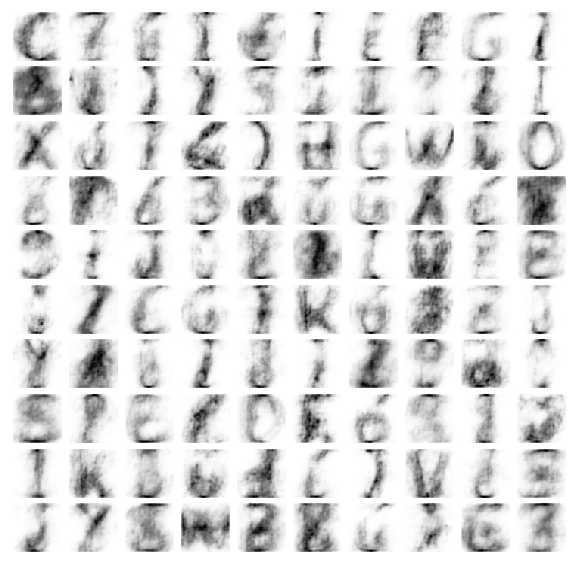

In [6]:
with tf.Session() as sess:
    
    sess.run(init)

    CVAE_BB_TO_HW_SAVER.restore(sess, save_path)
    print("Model restored in file: {}".format(save_path))
    
    random_gen = sess.run(x_sample,feed_dict={z_input: np.random.randn(100, z_dim)})
    
    fig=plot(random_gen, 10, 10, 10, 10, 70, 70)
    plt.show()

    
                            

INFO:tensorflow:Restoring parameters from MODELS_CVAE/CONV_VAE_BB_TO_HW.ckpt
Model restored in file: MODELS_CVAE/CONV_VAE_BB_TO_HW.ckpt


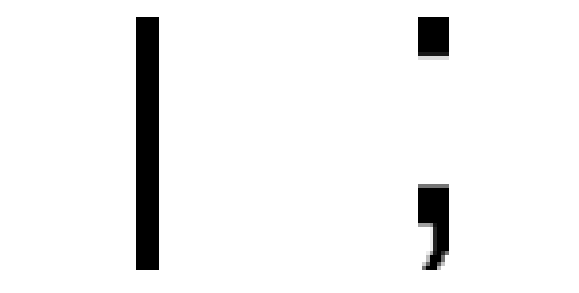

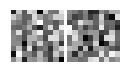

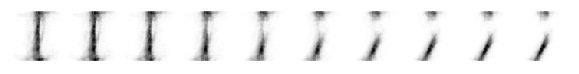

In [10]:
with tf.Session() as sess:
    
    sess.run(init)

    CVAE_BB_TO_HW_SAVER.restore(sess, save_path)
    print("Model restored in file: {}".format(save_path))
    
    INTERPOLATION_STEPS = 10
    alphaValues = np.linspace(0, 1, INTERPOLATION_STEPS)
    
    random_indexes = np.random.permutation(X_original_matching.shape[0])[:2]
    
    x_samples = X_original_matching[random_indexes].copy()
    
    x_samples_reshape = x_samples.reshape((x_samples.shape[0], 70 * 70))
    
    z_projected_samples = sess.run(z, feed_dict={images: x_samples_reshape})
    
    fig=plot(x_samples, 1, 2, 10, 10, 70, 70)
    plt.show()
    
    fig=plot(z_projected_samples, 10, 10, 10, 10, 10, 10)
    plt.show()
    
    z_samples_interpolated = np.zeros((INTERPOLATION_STEPS, z_dim))
    
    for i, alpha in enumerate(alphaValues):
        z_samples_interpolated[i] = z_projected_samples[0]*(1-alpha) + z_projected_samples[1]*alpha
        
    
    x_interpolated = sess.run(x_sample, feed_dict={z_input: z_samples_interpolated})
    
    fig=plot(x_interpolated, 1, INTERPOLATION_STEPS, 10, 10, 70, 70)
    plt.show()
    
    
    